<a href="https://colab.research.google.com/github/Vishwaak/Time-for-Machine/blob/master/Save_and_Load_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 114688/26421880 [00:00<00:22, 1146225.22it/s]

26427392it [00:00, 81392483.16it/s]                             


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 552087.83it/s]
 10%|▉         | 434176/4422102 [00:00<00:00, 4340977.56it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 30246889.55it/s]                           
8192it [00:00, 186294.25it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
image, label = next(iter(trainloader))

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
# TODO: Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [0]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5189460875954963
Training loss: 0.3930190469918729
Training loss: 0.3554112941725676
Training loss: 0.3307421572530257
Training loss: 0.31786281673479944


In [0]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

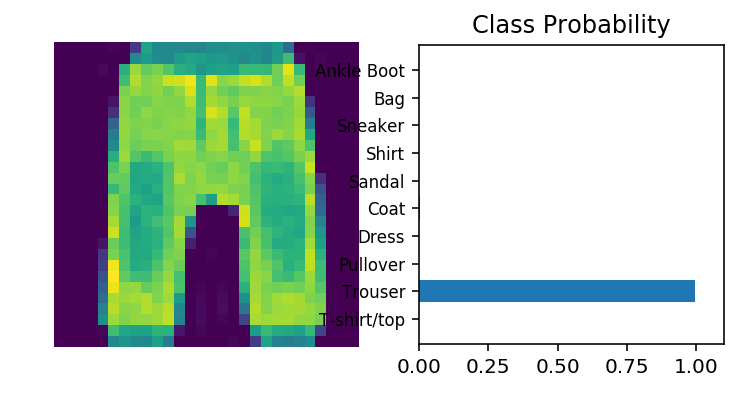

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(testloader)
images , labels = dataiter.next()
img = images[1]
img = img.view(img.shape[0] , -1)
ps = torch.exp(model(img))

view_classify(img , ps , version='Fashion')

In [0]:
#code for fc_model

class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
model.train()

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [0]:
model = Network(784,10 ,[512,256,128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters() ,lr =0.003)

In [0]:
train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 0.781..  Test Loss: 0.579..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.544..  Test Loss: 0.600..  Test Accuracy: 0.790
Epoch: 1/2..  Training Loss: 0.572..  Test Loss: 0.528..  Test Accuracy: 0.807
Epoch: 1/2..  Training Loss: 0.507..  Test Loss: 0.511..  Test Accuracy: 0.817
Epoch: 1/2..  Training Loss: 0.453..  Test Loss: 0.493..  Test Accuracy: 0.825
Epoch: 1/2..  Training Loss: 0.480..  Test Loss: 0.514..  Test Accuracy: 0.825
Epoch: 1/2..  Training Loss: 0.496..  Test Loss: 0.514..  Test Accuracy: 0.805
Epoch: 1/2..  Training Loss: 0.456..  Test Loss: 0.479..  Test Accuracy: 0.831
Epoch: 1/2..  Training Loss: 0.492..  Test Loss: 0.471..  Test Accuracy: 0.825
Epoch: 1/2..  Training Loss: 0.462..  Test Loss: 0.475..  Test Accuracy: 0.834
Epoch: 1/2..  Training Loss: 0.425..  Test Loss: 0.497..  Test Accuracy: 0.818
Epoch: 1/2..  Training Loss: 0.459..  Test Loss: 0.486..  Test Accuracy: 0.822
Epoch: 1/2..  Training Loss: 0.502..  Test Loss: 0.4

In [0]:
print("our model:  " , model , '\n')
print(model.state_dict().keys())

our model:   Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [0]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [0]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [0]:
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
torch.cuda.torch.cuda.is_available()

True